In [32]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import math
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization
import cv2
import keras
from keras_cv import models, losses, callbacks
import keras_cv.losses as losses
from keras_cv.models import YOLOV8Detector

## Visualization

In [2]:
IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 3  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing

In [3]:
# Paths to the datasets
TRAIN_IMAGES_DIR = "dataset/train/images/"
TRAIN_LABELS_DIR = "dataset/train/labels/"

VAL_IMAGES_DIR = "dataset/val/images/"
VAL_LABELS_DIR = "dataset/val/labels/"

In [4]:
# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).resize(IMAGE_SIZE)  # Resize
    image = np.array(image) / 255.0  # Normalize
    return image.astype(np.float32)

In [5]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [6]:
# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [7]:
# Data loader with flexible batch size and error handling
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    # Map function to load images and annotations with error handling
    dataset = dataset.map(
        lambda x: tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [x],
            [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Apply batching, allowing for partial batches
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [8]:
# Create a resizing layer for inference
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1],
    bounding_box_format=BOUNDING_BOX_FORMAT,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO
)


In [9]:
# Function to count elements in a dataset
def count_elements(dataset):
    return dataset.cardinality().numpy()

# Check if the dataset is empty
def is_dataset_empty(dataset):
    return count_elements(dataset) <= 0

In [10]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [11]:
# Function to normalize image data
def normalize_image_data(image):
    # Convert TensorFlow tensor to NumPy array
    image = image.numpy()  # Explicit conversion
    # If data is in float format, scale to [0, 255]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image


In [12]:
# Function to convert from BGR to RGB if needed
def ensure_rgb_format(image):
    # If the image appears incorrect, try converting BGR to RGB
    if image.shape[-1] == 3:  # Assuming three channels (RGB or BGR)
        return image[..., ::-1]  # Reverse the color channels to convert BGR to RGB
    return image


In [13]:
# Visualization function to plot bounding boxes with proper normalization
def visualize_dataset(dataset, value_range, default_rows, default_cols, bounding_box_format):
    # Get the first batch from the dataset
    batch = next(iter(dataset.take(1)))  # Get the first batch
    
    # Extract images and raw bounding boxes
    images, bounding_boxes_raw = batch
    
    # Normalize image data and ensure correct color space
    # Convert TensorFlow tensors to NumPy arrays before applying NumPy operations
    images = np.array([normalize_image_data(img) for img in images])
    images = np.array([ensure_rgb_format(img) for img in images])
    
    # Ensure there are images to plot
    if images.shape[0] == 0:
        raise ValueError("No images found in the dataset.")

    # Adjust rows and columns based on available images
    total_images = images.shape[0]
    rows = min(default_rows, total_images)
    cols = math.ceil(total_images / rows)

    # Extract bounding boxes and class IDs
    bounding_boxes, class_ids = extract_bounding_box_info(bounding_boxes_raw)

    # Convert bounding box format
    bounding_boxes = keras_cv.bounding_box.convert_format(
        bounding_boxes,
        source=bounding_box_format,
        target="xywh",
    )

    # Create class mappings for visualization
    class_mapping = {int(cls): f"Class {cls}" for cls in np.unique(class_ids)}
    
    # Plot bounding boxes on images
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true={
            "classes": class_ids,
            "boxes": bounding_boxes,
        },
        scale=5,
        font_scale=0.7,
        bounding_box_format="xywh",
        class_mapping=class_mapping,
    )

In [14]:
# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE//2)

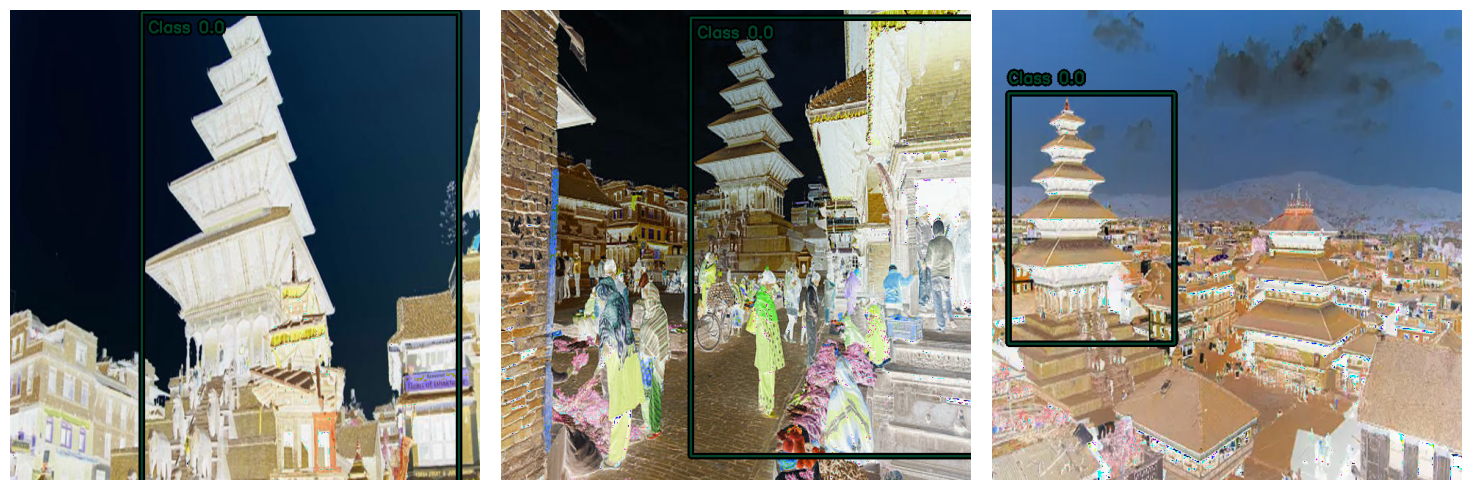

In [15]:
visualize_dataset(train_dataset, value_range=(0, 1), default_rows=1, default_cols=1, bounding_box_format="xywh")

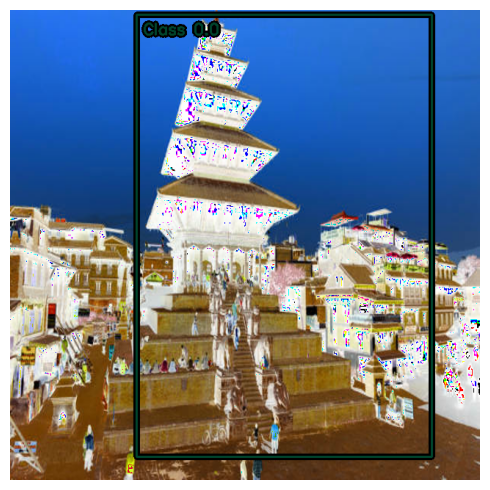

In [16]:
visualize_dataset(val_dataset, value_range=(0, 1), default_rows=1, default_cols=1, bounding_box_format="xywh")

## Model

In [23]:
# Specific optimizer and loss for YOLOv8
optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, global_clipnorm=10.0)

In [27]:
print(models.YOLOV8Detector.presets.keys()) 

dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resnet50_v

In [28]:
model = models.YOLOV8Detector.from_preset(
    "yolo_v8_xs_backbone_coco",
    bounding_box_format="xywh",
    num_classes=NUM_CLASSES,  # Adjust this based on your dataset
    input_shape=IMAGE_SIZE + (3,),  # (640, 640, 3)
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 667kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 5.11M/5.11M [00:02<00:00, 1.79MB/s]


In [34]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [35]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_dataset.take(20), bounding_box_format="xywh"
)

In [37]:
print(train_dataset.element_spec)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))


In [36]:
model.fit(
    train_dataset.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

ValueError: as_list() is not defined on an unknown TensorShape.